In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold


## Query - Item

In [2]:
df = pd.read_csv('/home/tnguyenho/workspace/e-commerce-product-search/data/translated/translated_train_QI_full.csv')
df[['origin_query', 'item_title', 'label']].head()

,origin_query,item_title,label
0,Apexel 60x telephoto lens,67mm Phone Filter Holder Mount Lens Filter Cli...,0
1,Apexel 60x telephoto lens,NEEWER Universal Phone Clamp for 17mm Threaded...,0
2,nighty,2PCS Leepwear Female Pajamas Set Satin Home Py...,1
3,nighty,Womens Pajama Sets Lace Shorts Homewear Solid ...,0
4,-40wd,Huina 1540 Rc Dump Truck 1:18 6 Ch 2.4G Alloy ...,0


In [3]:
# --- 1. Tổng quan và Chất lượng Dữ liệu ---
print("### 1. Tổng quan & Chất lượng Dữ liệu ###")
print(f"Kích thước dữ liệu (dòng, cột): {df.shape}\n")
print("Thông tin kiểu dữ liệu:")
df.info()
print("\nSố lượng giá trị thiếu mỗi cột:")
print(df.isnull().sum())
print(f"\nSố dòng trùng lặp: {df.duplicated().sum()}")
print("-" * 30 + "\n")

### 1. Tổng quan & Chất lượng Dữ liệu ###
Kích thước dữ liệu (dòng, cột): (340000, 7)

Thông tin kiểu dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340000 entries, 0 to 339999
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                340000 non-null  int64 
 1   task              340000 non-null  object
 2   language          340000 non-null  object
 3   origin_query      340000 non-null  object
 4   item_title        339547 non-null  object
 5   label             340000 non-null  int64 
 6   translated_query  340000 non-null  object
dtypes: int64(2), object(5)
memory usage: 18.2+ MB

Số lượng giá trị thiếu mỗi cột:
id                    0
task                  0
language              0
origin_query          0
item_title          453
label                 0
translated_query      0
dtype: int64

Số dòng trùng lặp: 0
------------------------------



In [4]:
# show row df['item_title'] is nan
df[df['item_title'].isna()][['origin_query', 'item_title','label']]

,origin_query,item_title,label
78,1/4 cups women,NaN,0
972,2x6 hd lace closure brown,NaN,0
1250,4497eq,NaN,0
2003,Chromecast,NaN,0
2055,Curly Wigs,NaN,1
...,...,...,...
289467,wig cabelo humano,NaN,1
289468,wig cabelo humano,NaN,1
289571,xiaomi 14t versão global,NaN,0
289811,ácido hialurônico reticulado injetável,NaN,0


In [5]:
# show row df['item_title'] is nan but label is 1
df[df['item_title'].isna() & df['label'] == 1][['origin_query', 'item_title','label']]

,origin_query,item_title,label
2055,Curly Wigs,NaN,1
2496,Lego,NaN,1
2497,Lego,NaN,1
2828,Rechargeable Batteries,NaN,1
2829,Rechargeable Batteries,NaN,1
...,...,...,...
287290,turbina roletada t3,NaN,1
288818,vestido soltinho,NaN,1
288819,vestido soltinho,NaN,1
289467,wig cabelo humano,NaN,1


In [6]:
df = df.dropna(subset=['item_title'])

In [7]:
# --- 2. Phân tích Phân phối ---
print("### 2. Phân tích Phân phối ###")
# Phân phối của 'label'
print("Phân phối của 'label' (%):")
print(df['label'].value_counts(normalize=True) * 100)


### 2. Phân tích Phân phối ###
Phân phối của 'label' (%):
label
1    62.426704
0    37.573296
Name: proportion, dtype: float64


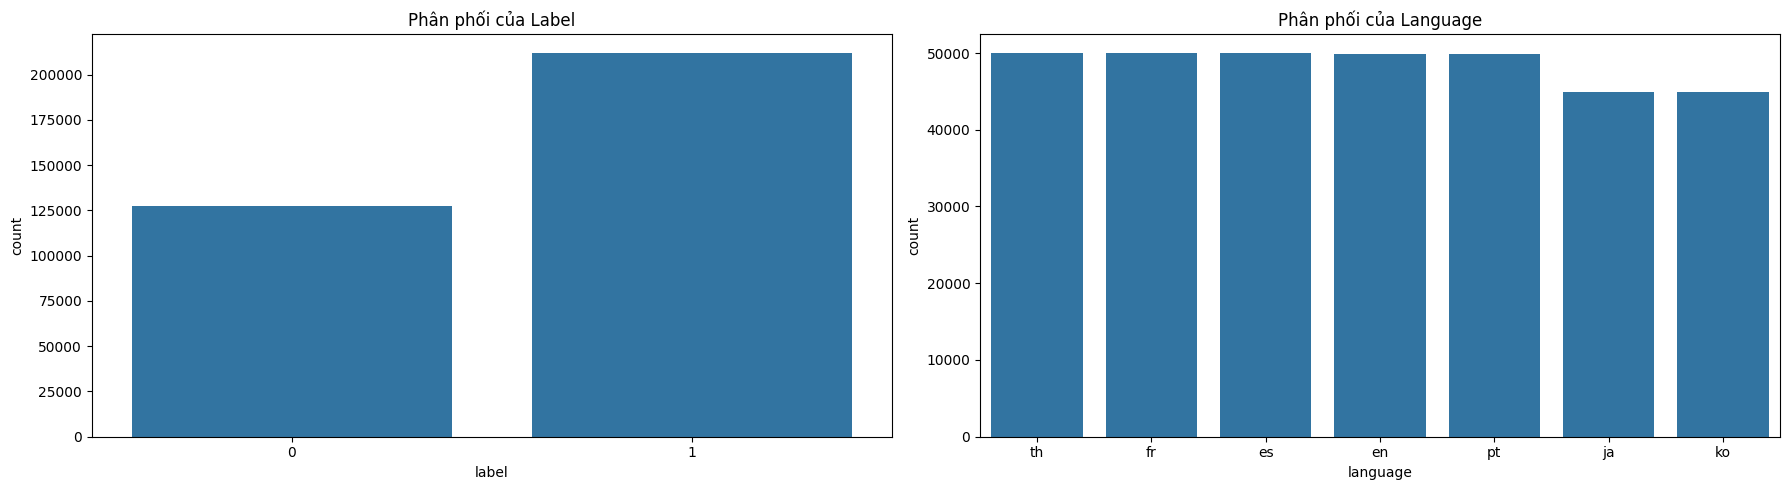

In [8]:

# Vẽ biểu đồ phân phối
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='label', data=df)
plt.title('Phân phối của Label')

plt.subplot(1, 2, 2)
sns.countplot(x='language', data=df, order=df['language'].value_counts().index)
plt.title('Phân phối của Language')


plt.tight_layout()
# plt.savefig('distribution_plots.png')
# print("\nĐã lưu biểu đồ phân phối vào 'distribution_plots.png'")
# print("-" * 30 + "\n")

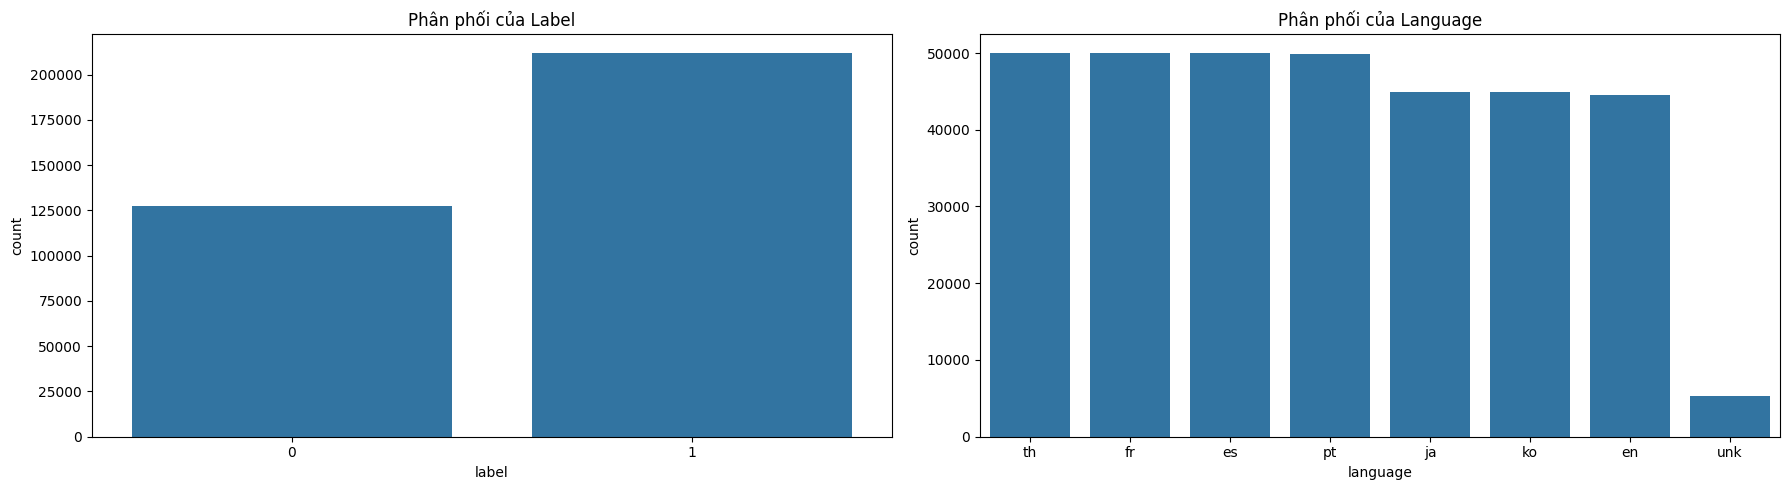

In [9]:
df['language'] = df.apply(lambda x: 'unk' if ( x['language'] == 'en' and x['origin_query'].lower() != x['translated_query'].lower()) else x['language'], axis=1)


# Vẽ biểu đồ phân phối
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='label', data=df)
plt.title('Phân phối của Label')

plt.subplot(1, 2, 2)
sns.countplot(x='language', data=df, order=df['language'].value_counts().index)
plt.title('Phân phối của Language')


plt.tight_layout()
# plt.savefig('distribution_plots.png')
# print("\nĐã lưu biểu đồ phân phối vào 'distribution_plots.png'")
# print("-" * 30 + "\n")

Bảng tần số tuyệt đối giữa Language và Label:
label         0      1
language              
en        16510  28042
es        15876  34073
fr        17915  32041
ja        17237  27701
ko        17880  27039
pt        17313  32558
th        22660  27339
unk        2188   3175


Bảng tỉ lệ (%) của Label trong mỗi Language:
label          0       1
language                
en        37.06%  62.94%
es        31.78%  68.22%
fr        35.86%  64.14%
ja        38.36%  61.64%
ko         39.8%   60.2%
pt        34.72%  65.28%
th        45.32%  54.68%
unk        40.8%   59.2%




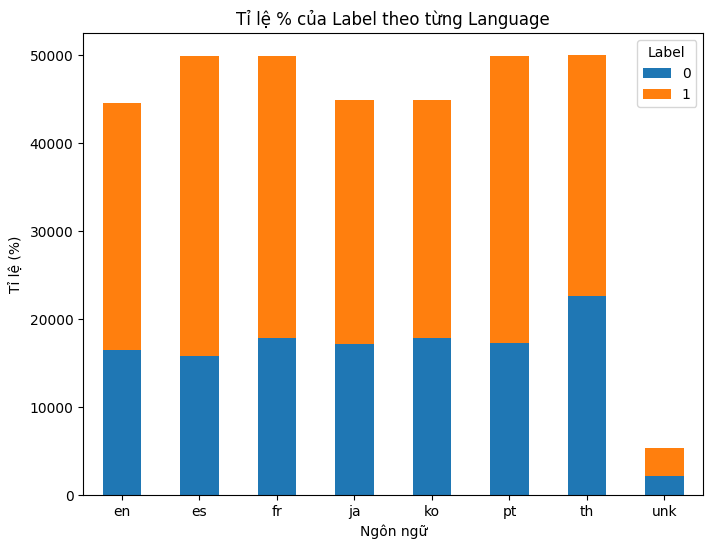

In [10]:
# --- Phân tích mối quan hệ giữa Language và Label ---

# 1. Tạo bảng tần số chéo (crosstab) để xem số lượng tuyệt đối
print("Bảng tần số tuyệt đối giữa Language và Label:")
absolute_crosstab = pd.crosstab(df['language'], df['label'])
print(absolute_crosstab)
print("\n" + "="*40 + "\n")

# 2. Tính toán tỉ lệ phần trăm cho mỗi ngôn ngữ
# normalize='index' sẽ tính tỉ lệ theo hàng (tổng của mỗi hàng là 100%)
print("Bảng tỉ lệ (%) của Label trong mỗi Language:")
percentage_crosstab = pd.crosstab(df['language'], df['label'], normalize='index') * 100

# In ra kết quả đã được làm tròn và thêm ký hiệu %
print(percentage_crosstab.round(2).astype(str) + '%')
print("\n" + "="*40 + "\n")

# 3. Trực quan hóa bằng biểu đồ cột chồng phần trăm
# Sử dụng lại bảng tần số tuyệt đối và vẽ biểu đồ cột chồng 100%
absolute_crosstab.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Tỉ lệ % của Label theo từng Language')
plt.ylabel('Tỉ lệ (%)')
plt.xlabel('Ngôn ngữ')
plt.xticks(rotation=0) # Giữ cho nhãn trục x nằm ngang
plt.legend(title='Label')
plt.show()


### 3. Phân tích Dữ liệu Văn bản ###



10 từ phổ biến nhất trong 'origin_query':
[('para', 12445), ('mujer', 3477), ('femme', 3438), ('เส', 3340), ('led', 2761), ('pro', 2691), ('iphone', 2551), ('pour', 2309), ('อง', 2150), ('hombre', 2069)]

10 từ phổ biến nhất trong 'item_title':
[('women', 50004), ('men', 32244), ('car', 31048), ('new', 26278), ('bag', 21574), ('accessories', 21291), ('cover', 20442), ('case', 19493), ('fashion', 19414), ('set', 18851)]
------------------------------



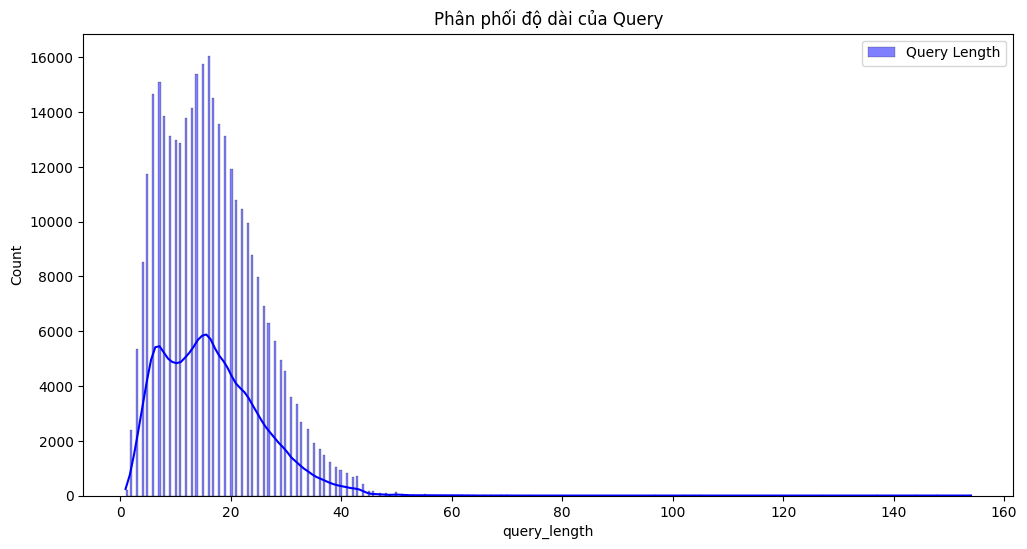

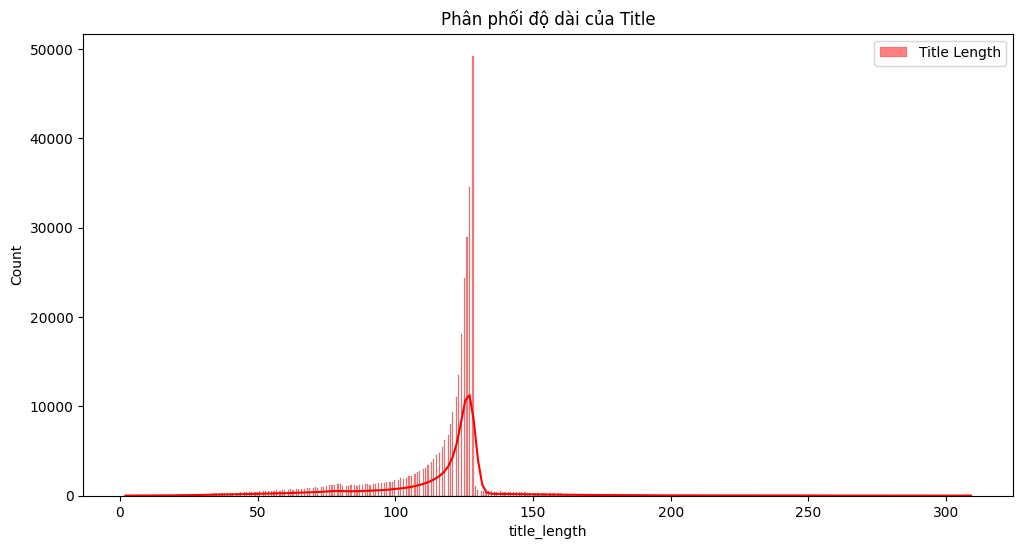

In [11]:
# --- 3. Phân tích Dữ liệu Văn bản ---
print("### 3. Phân tích Dữ liệu Văn bản ###")
# Thêm cột độ dài cho query và title
df['query_length'] = df['origin_query'].str.len()
df['title_length'] = df['item_title'].str.len()

# Vẽ biểu đồ phân phối độ dài
plt.figure(figsize=(12, 6))
sns.histplot(df['query_length'], color='blue', label='Query Length', kde=True)
plt.title('Phân phối độ dài của Query')
plt.legend()

plt.figure(figsize=(12, 6))
sns.histplot(df['title_length'], color='red', label='Title Length', kde=True)
plt.title('Phân phối độ dài của Title')
plt.legend()
# plt.savefig('text_length_distribution.png')
# print("Đã lưu biểu đồ phân phối độ dài văn bản vào 'text_length_distribution.png'")

# Hàm lấy N từ/cụm từ phổ biến nhất
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Lấy 10 từ phổ biến nhất trong query và title
top_query_words = get_top_ngrams(df['origin_query'], n=10)
top_title_words = get_top_ngrams(df['item_title'], n=10)

print("\n10 từ phổ biến nhất trong 'origin_query':")
print(top_query_words)

print("\n10 từ phổ biến nhất trong 'item_title':")
print(top_title_words)
print("-" * 30 + "\n")
# NEU LANG SAI THI SAO?

In [12]:
# show rows (query length >50)
df[df['query_length'] > 50]['origin_query'].head()

657     200 Density 13x4 13x6 HD Lace Frontal Human Ha...
658     200 Density 13x4 13x6 HD Lace Frontal Human Ha...
2548    M6  Steel Flange Thread Nut Coupling Rigid Fla...
2549    M6  Steel Flange Thread Nut Coupling Rigid Fla...
2920    Shein Mens Black Flap Pocket Drawstring Cargo ...
Name: origin_query, dtype: object

In [13]:
df[df['title_length'] < 50]['item_title'].head()

16                                     22 pcs ring set
34       892450D080  Steering Angle Sensor 89245-0D080
332             RYANLEY UNI FAN SL140 V2 BLACK (1PACK)
508      FMS 1:12 Type82 Kubelwagen RC Car Model Parts
802    Gooxi Server GeForce RTX 2080 Ti GPU for Server
Name: item_title, dtype: object

In [14]:
df[df['title_length'] > 130]['item_title'].head()

136    TATAK PINOY Hair Grower Castor Oil Certified O...
137    [ Buy 1 Take 1 ] Original Hair Thick Shampoo H...
200    CASEIER เคสโทรศัพท์ลายดอกแดนดิไลอันหรูหราเคสโท...
203    เคสโทรศัพท์ชุบโลหะ6D สีสันสดใสเคสโทรศัพท์ลายกา...
246    Portable Ceramic Heater 1200W electric heater ...
Name: item_title, dtype: object

### 3. Phân tích Dữ liệu Văn bản ###

10 từ phổ biến nhất trong 'translated_query':
[('women', 7566), ('case', 7044), ('car', 6202), ('bag', 5838), ('men', 5399), ('shirt', 4332), ('woman', 4175), ('dress', 3993), ('man', 3925), ('cover', 3695)]

10 từ phổ biến nhất trong 'item_title':
[('women', 50004), ('men', 32244), ('car', 31048), ('new', 26278), ('bag', 21574), ('accessories', 21291), ('cover', 20442), ('case', 19493), ('fashion', 19414), ('set', 18851)]
------------------------------



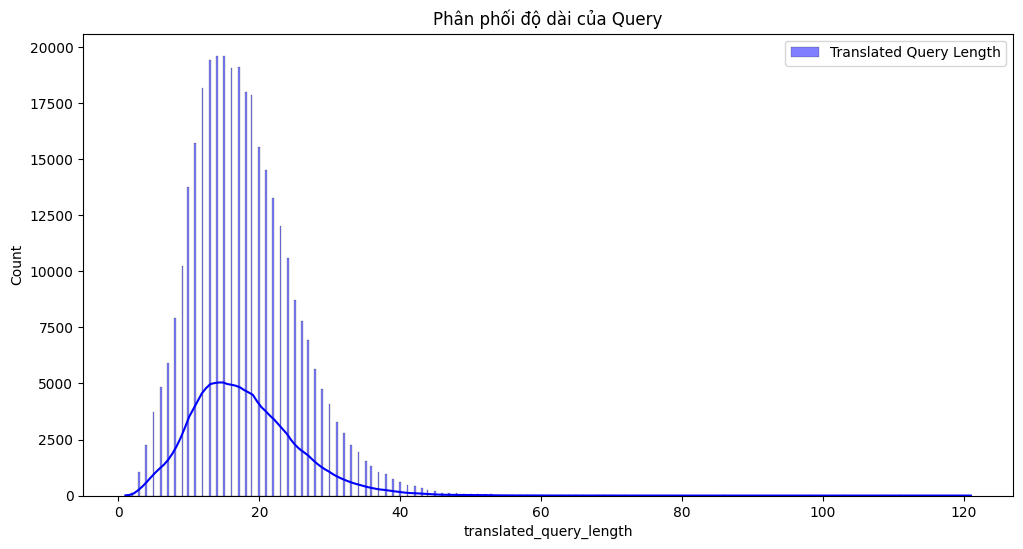

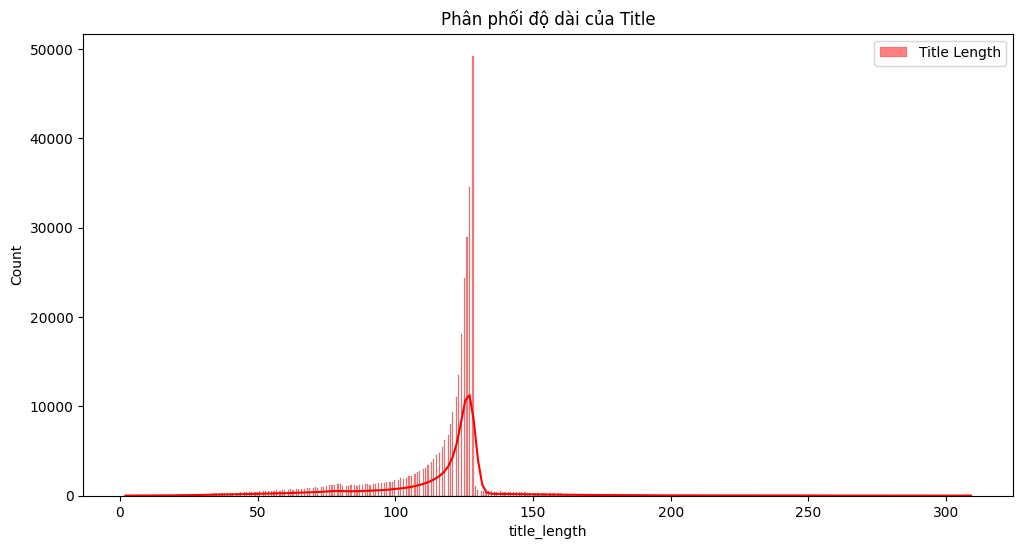

In [15]:
# --- 3. Phân tích Dữ liệu Văn bản ---
print("### 3. Phân tích Dữ liệu Văn bản ###")
# Thêm cột độ dài cho query và title
df['translated_query_length'] = df['translated_query'].str.len()
df['title_length'] = df['item_title'].str.len()

# Vẽ biểu đồ phân phối độ dài
plt.figure(figsize=(12, 6))
sns.histplot(df['translated_query_length'], color='blue', label='Translated Query Length', kde=True)
plt.title('Phân phối độ dài của Query')
plt.legend()

plt.figure(figsize=(12, 6))
sns.histplot(df['title_length'], color='red', label='Title Length', kde=True)
plt.title('Phân phối độ dài của Title')
plt.legend()
# plt.savefig('text_length_distribution.png')
# print("Đã lưu biểu đồ phân phối độ dài văn bản vào 'text_length_distribution.png'")

# Hàm lấy N từ/cụm từ phổ biến nhất
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Lấy 10 từ phổ biến nhất trong query và title
top_query_words = get_top_ngrams(df['translated_query'], n=10)
top_title_words = get_top_ngrams(df['item_title'], n=10)

print("\n10 từ phổ biến nhất trong 'translated_query':")
print(top_query_words)

print("\n10 từ phổ biến nhất trong 'item_title':")
print(top_title_words)
print("-" * 30 + "\n")

In [16]:
# show rows (query length >50)
df[df['translated_query_length'] > 60]['translated_query'].head()

657     200 Density 13x4 13x6 HD Lace Frontal Human Ha...
658     200 Density 13x4 13x6 HD Lace Frontal Human Ha...
2548    M6  Steel Flange Thread Nut Coupling Rigid Fla...
2549    M6  Steel Flange Thread Nut Coupling Rigid Fla...
3071    Tableware Disposable Kitchenware Table Decorat...
Name: translated_query, dtype: object

In [17]:
df[df['translated_query_length'] > 60]['translated_query'].iloc[0]

'200 Density 13x4 13x6 HD Lace Frontal Human Hair Wigs Straight'


Đã lưu biểu đồ mối quan hệ độ dài và label vào 'length_vs_label.png'


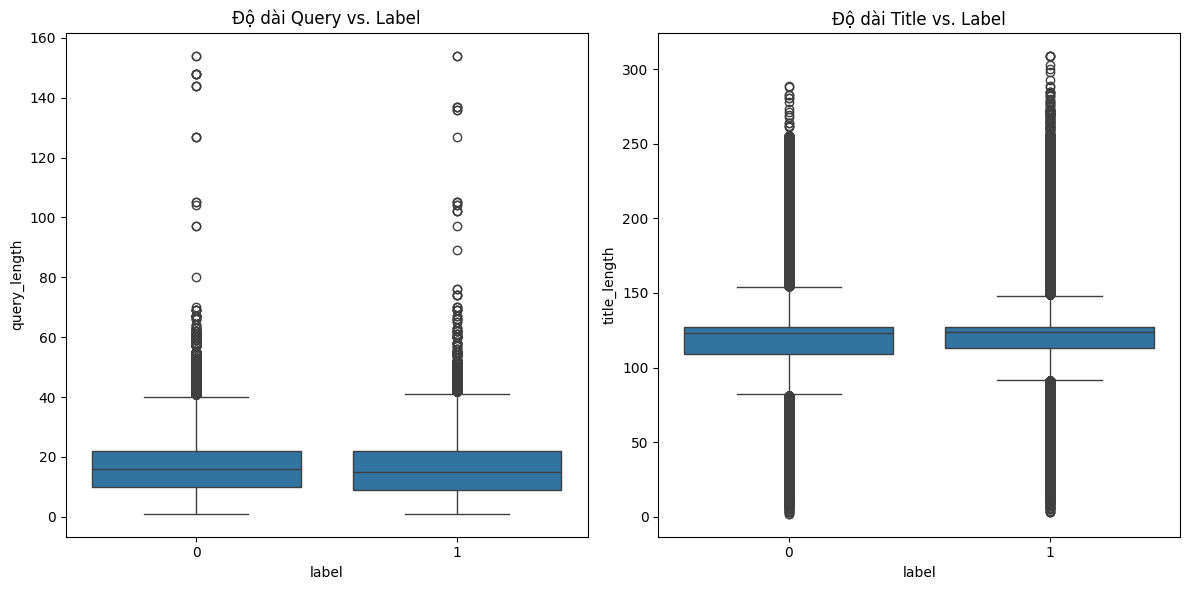

In [18]:
# Mối quan hệ giữa độ dài văn bản và Label
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='query_length', data=df)
plt.title('Độ dài Query vs. Label')
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='title_length', data=df)
plt.title('Độ dài Title vs. Label')
plt.tight_layout()
plt.savefig('length_vs_label.png')
print("\nĐã lưu biểu đồ mối quan hệ độ dài và label vào 'length_vs_label.png'")



Thống kê về độ tương đồng Jaccard theo label:
          count      mean       std  min  25%  50%       75%       max
label                                                                 
0      127579.0  0.023447  0.045253  0.0  0.0  0.0  0.045455  0.666667
1      211968.0  0.032868  0.056935  0.0  0.0  0.0  0.052632  1.000000
------------------------------



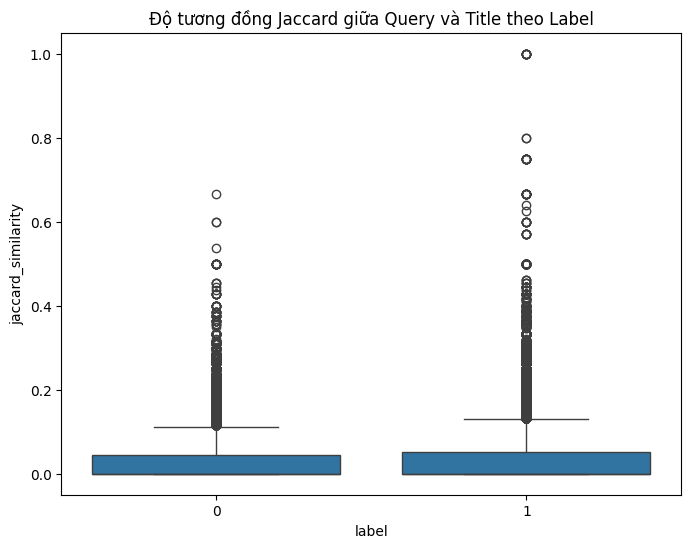

In [19]:
# Tính độ tương đồng Jaccard (mức độ trùng lặp từ)
def jaccard_similarity(query, title):
    query_set = set(str(query).lower().split())
    title_set = set(str(title).lower().split())
    intersection = query_set.intersection(title_set)
    union = query_set.union(title_set)
    if not union:
        return 0.0
    return len(intersection) / len(union)

df['jaccard_similarity'] = df.apply(lambda row: jaccard_similarity(row['origin_query'], row['item_title']), axis=1)

# So sánh độ tương đồng Jaccard theo Label
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='jaccard_similarity', data=df)
plt.title('Độ tương đồng Jaccard giữa Query và Title theo Label')
# plt.savefig('jaccard_vs_label.png')
# print("Đã lưu biểu đồ Jaccard và label vào 'jaccard_vs_label.png'")

print("\nThống kê về độ tương đồng Jaccard theo label:")
print(df.groupby('label')['jaccard_similarity'].describe())
print("-" * 30 + "\n")


Thống kê về độ tương đồng Jaccard theo label:
          count      mean       std  min  25%       50%       75%  max
label                                                                 
0      127579.0  0.048482  0.058014  0.0  0.0  0.045455  0.076923  1.0
1      211968.0  0.078757  0.070673  0.0  0.0  0.062500  0.117647  1.0
------------------------------



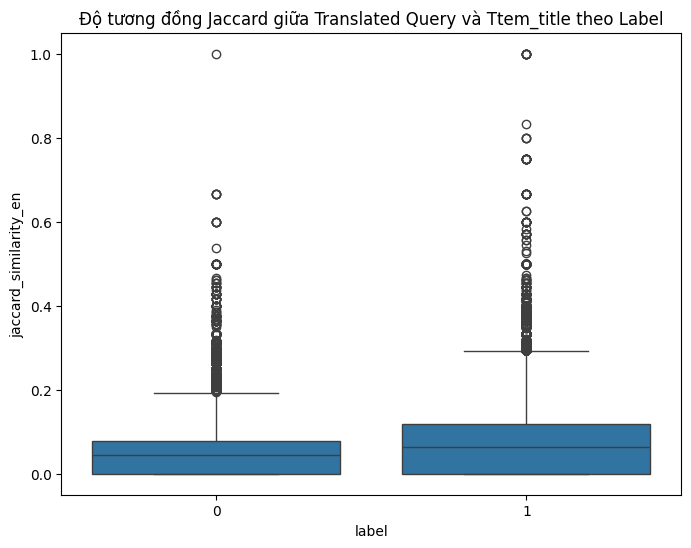

In [20]:

df['jaccard_similarity_en'] = df.apply(lambda row: jaccard_similarity(row['translated_query'], row['item_title']), axis=1)

# So sánh độ tương đồng Jaccard theo Label
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='jaccard_similarity_en', data=df)
plt.title('Độ tương đồng Jaccard giữa Translated Query và Ttem_title theo Label')
# plt.savefig('jaccard_vs_label.png')
# print("Đã lưu biểu đồ Jaccard và label vào 'jaccard_vs_label.png'")

print("\nThống kê về độ tương đồng Jaccard theo label:")
print(df.groupby('label')['jaccard_similarity_en'].describe())
print("-" * 30 + "\n")

In [33]:
sorted(df['language'].unique().tolist())

['en', 'es', 'fr', 'ja', 'ko', 'pt', 'th', 'unk']

### dev

In [24]:
df_dev = pd.read_csv('/home/tnguyenho/workspace/e-commerce-product-search/data/translated/translated_dev_QI_full.csv')
df_dev[['origin_query', 'item_title']].head()

,origin_query,item_title
0,الانترا,Ford Performance Car Front Window Hood Engine ...
1,ايفون xr,"Genuine Apple iPhone XR Original 6.1\"" Retina ..."
2,100 دولار مزيف,100 PCS/Box Solid Colour False Nail Tips Fake ...
3,100 دولار مزيف,100Pcs/Box Black Matte False Nail Tips Reusabl...
4,100 دولار مزيف,100pcs Acrylic Nails Fake Capsule Short Almond...


In [27]:
# --- 1. Tổng quan và Chất lượng Dữ liệu ---
print("### 1. Tổng quan & Chất lượng Dữ liệu ###")
print(f"Kích thước dữ liệu (dòng, cột): {df_dev.shape}\n")
print("Thông tin kiểu dữ liệu:")
df_dev.info()
print("\nSố lượng giá trị thiếu mỗi cột:")
print(df_dev.isnull().sum())
print(f"\nSố dòng trùng lặp: {df_dev.duplicated().sum()}")
print("-" * 30 + "\n")

### 1. Tổng quan & Chất lượng Dữ liệu ###
Kích thước dữ liệu (dòng, cột): (65000, 6)

Thông tin kiểu dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65000 entries, 0 to 64999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                65000 non-null  int64 
 1   task              65000 non-null  object
 2   language          65000 non-null  object
 3   origin_query      65000 non-null  object
 4   item_title        64999 non-null  object
 5   translated_query  65000 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.0+ MB

Số lượng giá trị thiếu mỗi cột:
id                  0
task                0
language            0
origin_query        0
item_title          1
translated_query    0
dtype: int64

Số dòng trùng lặp: 0
------------------------------



In [37]:
df_dev = df_dev.dropna(subset=['item_title'])

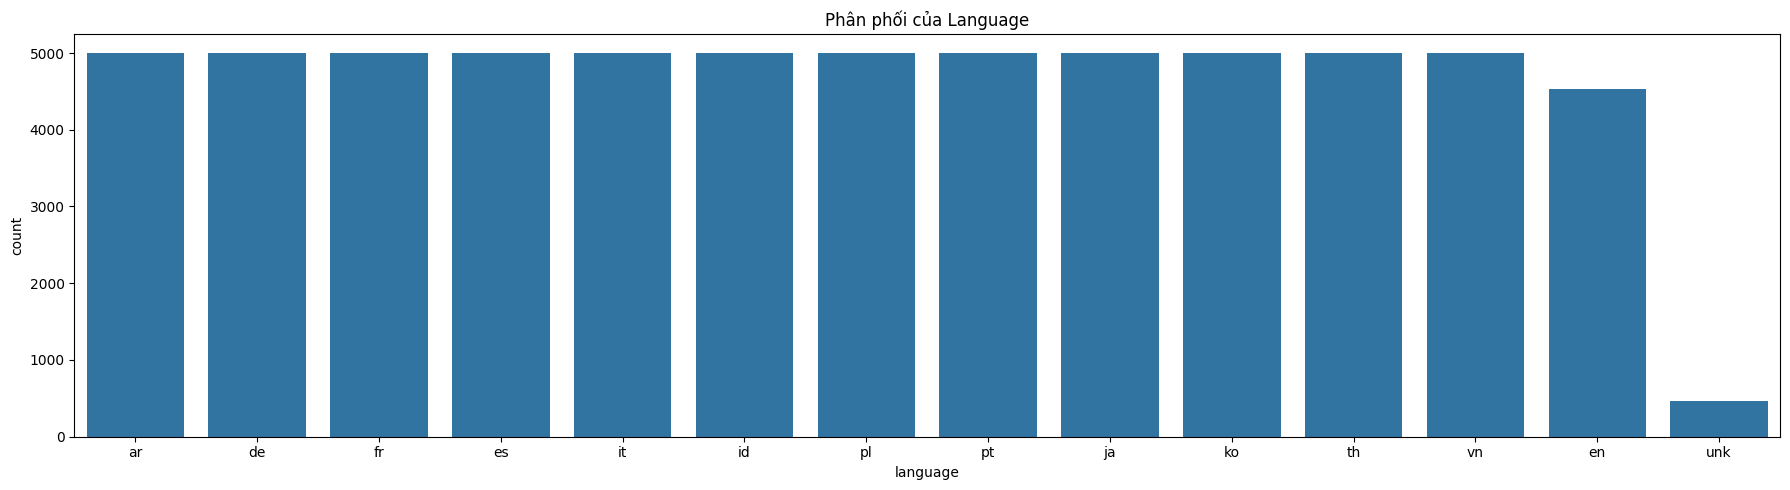

In [29]:
df_dev['language'] = df_dev.apply(lambda x: 'unk' if ( x['language'] == 'en' and x['origin_query'].lower() != x['translated_query'].lower()) else x['language'], axis=1)


# Vẽ biểu đồ phân phối
plt.figure(figsize=(18, 5))
sns.countplot(x='language', data=df_dev, order=df_dev['language'].value_counts().index)
plt.title('Phân phối của Language')


plt.tight_layout()
# plt.savefig('distribution_plots.png')
# print("\nĐã lưu biểu đồ phân phối vào 'distribution_plots.png'")
# print("-" * 30 + "\n")

In [32]:
sorted(df_dev['language'].unique().tolist())

['ar',
 'de',
 'en',
 'es',
 'fr',
 'id',
 'it',
 'ja',
 'ko',
 'pl',
 'pt',
 'th',
 'unk',
 'vn']

### 3. Phân tích Dữ liệu Văn bản ###


/tmp/ipykernel_597041/763184681.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dev['translated_query_length'] = df_dev['translated_query'].str.len()
/tmp/ipykernel_597041/763184681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dev['title_length'] = df_dev['item_title'].str.len()



10 từ phổ biến nhất trong 'translated_query':
[('women', 1621), ('case', 1518), ('iphone', 1142), ('men', 1132), ('car', 1115), ('bag', 979), ('accessories', 953), ('pro', 876), ('shoes', 835), ('shirt', 686)]

10 từ phổ biến nhất trong 'item_title':
[('women', 6803), ('car', 5863), ('case', 4904), ('cover', 4803), ('men', 4780), ('accessories', 4079), ('new', 4024), ('pro', 3863), ('bag', 3289), ('mini', 3240)]
------------------------------



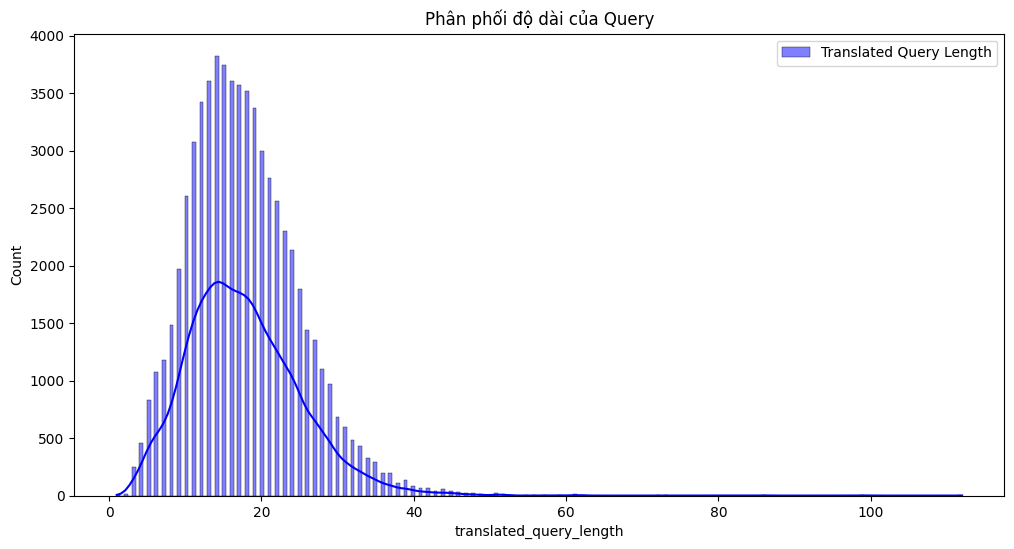

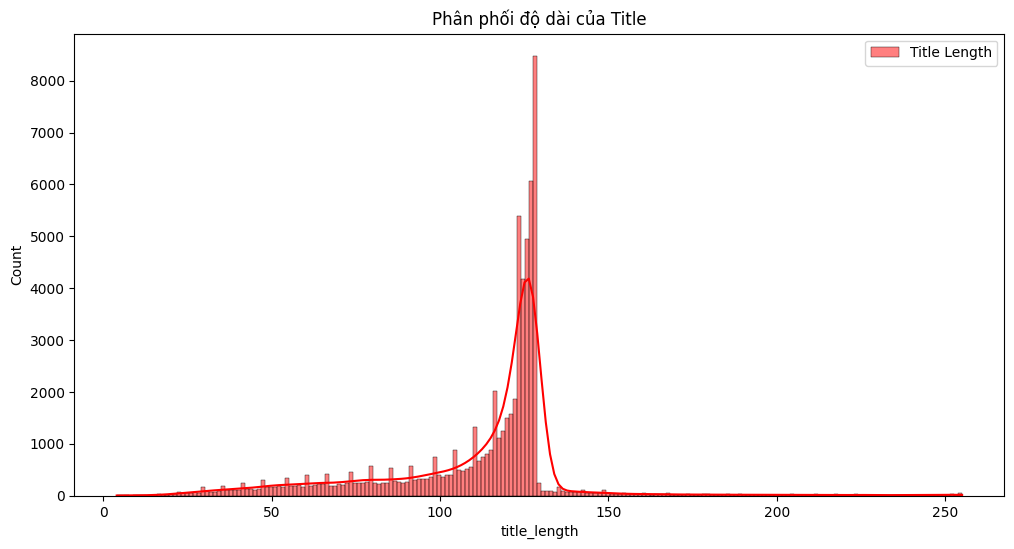

In [38]:
# --- 3. Phân tích Dữ liệu Văn bản ---
print("### 3. Phân tích Dữ liệu Văn bản ###")
# Thêm cột độ dài cho query và title
df_dev['translated_query_length'] = df_dev['translated_query'].str.len()
df_dev['title_length'] = df_dev['item_title'].str.len()

# Vẽ biểu đồ phân phối độ dài
plt.figure(figsize=(12, 6))
sns.histplot(df_dev['translated_query_length'], color='blue', label='Translated Query Length', kde=True)
plt.title('Phân phối độ dài của Query')
plt.legend()

plt.figure(figsize=(12, 6))
sns.histplot(df_dev['title_length'], color='red', label='Title Length', kde=True)
plt.title('Phân phối độ dài của Title')
plt.legend()
# plt.savefig('text_length_distribution.png')
# print("Đã lưu biểu đồ phân phối độ dài văn bản vào 'text_length_distribution.png'")

# Hàm lấy N từ/cụm từ phổ biến nhất
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Lấy 10 từ phổ biến nhất trong query và title
top_query_words = get_top_ngrams(df_dev['translated_query'], n=10)
top_title_words = get_top_ngrams(df_dev['item_title'], n=10)

print("\n10 từ phổ biến nhất trong 'translated_query':")
print(top_query_words)

print("\n10 từ phổ biến nhất trong 'item_title':")
print(top_title_words)
print("-" * 30 + "\n")

## KFold

In [1]:
from pathlib import Path
import pandas as pd 
import numpy as np
import random
from sklearn.model_selection import StratifiedGroupKFold
random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

In [2]:
file_path = Path('/home/tnguyenho/workspace/e-commerce-product-search/data/translated/translated_train_QI_full.csv')
out_path = file_path.parent / 'translated_train_QI_full_fold.csv'

In [3]:
df = pd.read_csv(file_path)

In [4]:
df['language'] = df.apply(lambda x: 'unk' if ( x['language'] == 'en' and x['origin_query'].lower() != x['translated_query'].lower()) else x['language'], axis=1)

In [6]:
df['fold'] = -1
df['stratify_col'] = df['language'].astype(str) + '_' + df['label'].astype(str)

# Initialize the splitter
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Generate folds

for i, (train_idx, val_idx) in enumerate(sgkf.split(X=df, y=df['stratify_col'], groups=df['origin_query'])):
    df.loc[val_idx, 'fold'] = i

# Verify that a single origin_query only exists in one fold
query_fold_counts = df.groupby('origin_query')['fold'].nunique()
print(f"Number of queries split across multiple folds: {(query_fold_counts > 1).sum()}")
# Expected output: Number of queries split across multiple folds: 0

print(df.fold.value_counts())

Number of queries split across multiple folds: 0
fold
1    68114
3    68110
4    68086
0    67889
2    67801
Name: count, dtype: int64


In [8]:
def detect_leakage(df: pd.DataFrame, group_col: str, fold_col: str = 'fold'):
    """
    Detects if any group appears in more than one fold, which would indicate
    leakage between training and validation sets.

    Args:
        df (pd.DataFrame): The dataframe containing the data and fold assignments.
        group_col (str): The name of the column to check for leakage (e.g., 'origin_query').
        fold_col (str): The name of the column containing the fold numbers.
    """
    print(f"--- Starting Leakage Detection for column: '{group_col}' ---")
    
    # Get all unique fold numbers, handling cases where folds might not start at 0 or be sequential
    folds = sorted(df[fold_col].unique())
    
    leakage_found = False
    for fold_num in folds:
        print(f"\nChecking Fold {fold_num}...")

        # Define the training and validation sets for the current fold
        train_df = df[df[fold_col] != fold_num]
        val_df = df[df[fold_col] == fold_num]

        # Get the unique group identifiers for each set
        train_groups = set(train_df[group_col].unique())
        val_groups = set(val_df[group_col].unique())

        # Find the intersection, which represents the leaked groups
        intersection = train_groups.intersection(val_groups)

        # some stats here:
        # number labels (train, val)
        # number main_category (train, val)
        # number language (train, val) 

        # print(f"Number of labels in (train, val): {train_df['label'].value_counts()}, {val_df['label'].value_counts()}")  
        print(f"Percentage of labels in (train):\n{train_df['label'].value_counts(normalize=True)}")
        print(f"Percentage of labels in (val):\n{val_df['label'].value_counts(normalize=True)}")
        print(f"Ratio of labels in (val): {val_df['label'].value_counts() / df['label'].value_counts()}")
        print(f"Number of language (train, val): {len(train_df['language'].unique()), len(val_df['language'].unique())}")
        if not intersection:
            print(f"  ✅ SUCCESS: No leakage found. Validation groups are unique to this fold.")
        else:
            print(f"  ❌ FAILED: Leakage detected! {len(intersection)} groups are in both train and val sets.")
            print(f"     Leaked groups: {intersection}")
            leakage_found = True
            
    print("\n--- Leakage Detection Complete ---")
    if not leakage_found:
        print("Overall Result: No leakage was detected across all folds. Your setup is correct!")
    else:
        print("Overall Result: Leakage was found. Review your folding strategy.")

detect_leakage(df=df, group_col='origin_query')


--- Starting Leakage Detection for column: 'origin_query' ---

Checking Fold 0...
Percentage of labels in (train):
label
1    0.623025
0    0.376975
Name: proportion, dtype: float64
Percentage of labels in (val):
label
1    0.628482
0    0.371518
Name: proportion, dtype: float64
Ratio of labels in (val): label
1    0.201071
0    0.197354
Name: count, dtype: float64
Number of language (train, val): (8, 8)
  ✅ SUCCESS: No leakage found. Validation groups are unique to this fold.

Checking Fold 1...
Percentage of labels in (train):
label
1    0.624166
0    0.375834
Name: proportion, dtype: float64
Percentage of labels in (val):
label
1    0.62391
0    0.37609
Name: proportion, dtype: float64
Ratio of labels in (val): label
1    0.200270
0    0.200444
Name: count, dtype: float64
Number of language (train, val): (8, 8)
  ✅ SUCCESS: No leakage found. Validation groups are unique to this fold.

Checking Fold 2...
Percentage of labels in (train):
label
1    0.623485
0    0.376515
Name: proport

In [9]:
df.to_csv(out_path, index=False)